In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

# Score by "in" cluster

- Measure sillhouette score of predicted phi-psi using clusters. Use this as score

In [3]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [23]:
(~ins.phi_psi_predictions.sil_score.isna()).sum()

0

In [26]:
from lib.utils import get_phi_psi_dist, calc_da
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

max_clusters = 7
ins = da
ins.xray_phi_psi['sil_score'] = np.nan
ins.phi_psi_predictions['sil_score'] = np.nan
ins.phi_psi_predictions['cluster'] = np.nan

for i,seq in enumerate(ins.xray_phi_psi.seq_ctxt.unique()):
    print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq}')
    if 'X' in seq:
        print(f'\tSkipping {seq} - X in sequence')
        continue
    phi_psi_dist, info = get_phi_psi_dist(ins.queries, seq)
    for i in info:
        print(f'\tWin {i[0]}: {i[1]} - {i[2]} samples')
    
    if phi_psi_dist.shape[0] < 2:
        print(f'\tSkipping {seq} - not enough samples')
        continue # leave as nan

    xray = ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq][['phi','psi']]
    if xray.shape[0] == 0:
        print(f'No xray seq {seq}')
        continue
    xray = xray.iloc[0].values

    preds = ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq]
    if preds.shape[0] == 0:
        print(f'No preds seq {seq}')
        continue

    max_sil_avg = -1
    one_cluster_wss = -1
    chosen_centroids = None
    for k in range(1, min(phi_psi_dist.shape[0], max_clusters)):
        kmeans = KMeans(n_clusters=k, n_init=10)
        labels = kmeans.fit_predict(phi_psi_dist[['phi', 'psi']])
        wss = kmeans.inertia_
        if k == 1:
            one_cluster_wss = wss
            phi_psi_dist['cluster'] = labels
            continue

        elif k == 2:
            if wss >= one_cluster_wss:
                break

        sil_avg = silhouette_score(phi_psi_dist[['phi', 'psi']], labels)
        if sil_avg > max_sil_avg:
            max_sil_avg = sil_avg
            phi_psi_dist['cluster'] = labels
            chosen_centroids = kmeans.cluster_centers_
    
    if chosen_centroids.shape[0] == 1:
        print(f'\tSkipping {seq} - only one cluster')
        continue

    dists = calc_da(xray, chosen_centroids)
    min_dist = np.min(dists)
    chosen_cluster_label = np.argmin(dists)

    sils = silhouette_samples(np.vstack([phi_psi_dist[['phi', 'psi']].values, xray]), np.append(phi_psi_dist.cluster.values, chosen_cluster_label))
    xray_sil = sils[-1]
    sils = sils[:-1]
    cluster_sils = {}
    for cluster_label in phi_psi_dist.cluster.unique():
        cluster_sils[cluster_label] = sils[phi_psi_dist.cluster.values == cluster_label].mean()

    xray_sil = (xray_sil + 1) / (cluster_sils[chosen_cluster_label] + 1)
    ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq, 'sil_score'] = xray_sil

    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)

    cluster_labels = np.argmin(np.linalg.norm(diff(preds[['phi', 'psi']].values[:,np.newaxis], chosen_centroids), axis=2), axis=1)
    preds.loc[:,'cluster'] = cluster_labels
    # calc silhouette score
    for cluster_label in preds.cluster.unique():
        these_preds = preds[preds.cluster == cluster_label]
        distance_to_points = np.linalg.norm(diff(these_preds[['phi', 'psi']].values[:,np.newaxis], phi_psi_dist[['phi', 'psi']].values), axis=2)
        a = distance_to_points[:, phi_psi_dist.cluster == cluster_label].mean(axis=1)
        b = distance_to_points[:, phi_psi_dist.cluster != cluster_label].mean(axis=1)
        sil = (b - a) / np.maximum(a, b)
        sil = (sil + 1) / (cluster_sils[cluster_label] + 1)
        # preds.loc[preds.cluster == cluster_label, 'sil_score'] = sil
        ins.phi_psi_predictions.loc[(ins.phi_psi_predictions.seq_ctxt == seq) & (preds.cluster == cluster_label), 'sil_score'] = sil
    
    # ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq, 'sil_score'] = preds.sil_score
    # print(f'Xray: {xray_sil:.2f}, Preds: {preds.sil_score.mean():.2f}')
    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # sns.scatterplot(phi_psi_dist, x='phi', y='psi', palette='Dark2', hue='cluster', ax=ax)
    # ax.scatter(xray[0], xray[1], marker='X', color='red', s=100, label='Xray')
    # sns.scatterplot(x=preds.phi, y=preds.psi, color='black', s=10, alpha=0.9, hue=preds.sil_score, ax=ax)
    # ax.set_xlim(-180, 180)
    # ax.set_ylim(-180, 180)

0/372: KEFWNLD
	Win 4: FWNL - 388 samples
	Win 5: EFWNL - 25 samples
	Win 6: EFWNLD - 0 samples
	Win 7: KEFWNLD - 0 samples
1/372: EFWNLDK
	Win 4: WNLD - 291 samples
	Win 5: FWNLD - 8 samples
	Win 6: FWNLDK - 0 samples
	Win 7: EFWNLDK - 0 samples
2/372: FWNLDKN
	Win 4: NLDK - 2550 samples
	Win 5: WNLDK - 42 samples
	Win 6: WNLDKN - 0 samples
	Win 7: FWNLDKN - 0 samples
3/372: WNLDKNL
	Win 4: LDKN - 2427 samples
	Win 5: NLDKN - 95 samples
	Win 6: NLDKNL - 8 samples
	Win 7: WNLDKNL - 0 samples
4/372: NLDKNLQ
	Win 4: DKNL - 3165 samples
	Win 5: LDKNL - 132 samples
	Win 6: LDKNLQ - 6 samples
	Win 7: NLDKNLQ - 0 samples
5/372: LDKNLQL
	Win 4: KNLQ - 2662 samples
	Win 5: DKNLQ - 31 samples
	Win 6: DKNLQL - 0 samples
	Win 7: LDKNLQL - 0 samples
6/372: DKNLQLR
	Win 4: NLQL - 1602 samples
	Win 5: KNLQL - 152 samples
	Win 6: KNLQLR - 24 samples
	Win 7: DKNLQLR - 0 samples
7/372: KNLQLRL
	Win 4: LQLR - 2892 samples
	Win 5: NLQLR - 138 samples
	Win 6: NLQLRL - 0 samples
	Win 7: KNLQLRL - 0 samples

In [27]:
da.xray_phi_psi.sort_values('sil_score')

,pos,seq_ctxt,res,phi,psi,protein_id,da,n_samples,n_samples_list,da_no_scale,sil_score
126,130,DASNAEN,N,-111.834049,161.721426,6t1z,7.850945,1639.0,"[1424, 207, 8, 0]",7.850945,0.096693
35,39,NQYLGSA,L,-118.253251,-178.325180,6t1z,165.678176,2437.0,"[2335, 102, 0, 0]",165.678176,0.303990
226,237,LSNSFKT,S,-144.888539,52.246372,6t1z,54.070270,939.0,"[900, 39, 0, 0]",54.070270,0.636807
315,332,NPEKIGS,K,-108.758528,34.339697,6t1z,14.708522,4154.0,"[4074, 80, 0, 0]",14.708522,0.651797
159,163,FRPAFEA,A,-126.754472,67.684924,6t1z,23.015634,1570.0,"[1480, 84, 6, 0]",23.015634,0.712069
...,...,...,...,...,...,...,...,...,...,...,...
36,40,QYLGSAI,G,-75.926941,173.971663,6t1z,160.136370,7718.0,"[7591, 127, 0, 0]",160.136370,1.068916
251,268,TLNRLTK,R,-55.715858,-44.667982,6t1z,9.460907,2393.0,"[2144, 226, 23, 0]",9.460907,1.071628
3,7,WNLDKNL,D,-66.325518,141.755098,6t1z,3.487576,2530.0,"[2427, 95, 8, 0]",3.487576,1.071943
231,248,QRMLTIY,L,-54.358420,-40.325213,6t1z,5.356483,811.0,"[795, 16, 0, 0]",5.356483,1.072148


In [29]:
da.casp_protein_id

'T1024'

In [37]:
da.results

,Model,GR#,GDT_TS,NP_P,RANK,Z-M1-GDT,Z-MA-GDT,GDT_HA,GDC_SC,GDC_ALL,...,CONTS,TMscore,Dali(raw),FlexE,QSE,CAD_SS,MolPrb_clash,MolPrb_rotout,MolPrb_ramout,MolPrb_ramfv
0,T1024TS427_3,427,79.22,100.0,1,NaN,2.09,60.67,46.80,53.52,...,96.86,0.93,6369.1,0.35,90.02,0.69,2.62,0.59,0.00,98.03
1,T1024TS427_5,427,71.67,100.0,2,NaN,1.50,51.98,38.22,44.45,...,96.61,0.88,5966.0,0.35,83.46,0.68,3.08,0.29,0.00,98.28
2,T1024TS226_5,226s,65.73,100.0,3,NaN,1.04,42.84,26.75,36.95,...,81.55,0.87,4599.4,3.40,NaN,0.39,3.85,2.35,2.22,91.87
3,T1024TS427_4,427,65.22,100.0,4,NaN,1.00,48.78,28.83,31.09,...,93.46,0.77,3500.6,1.44,68.42,0.65,1.69,0.59,0.00,98.28
4,T1024TS324_3,324s,65.15,100.0,5,NaN,1.00,42.52,25.94,36.11,...,85.42,0.86,4728.6,2.61,87.83,0.41,1.85,2.64,0.74,96.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,T1024TS170_4,170s,9.46,100.0,508,NaN,-3.32,4.79,1.52,2.94,...,41.23,0.23,440.5,201.20,NaN,0.07,0.00,0.59,0.74,92.36
508,T1024TS063_5,063s,9.02,100.0,509,NaN,-3.35,5.88,0.72,2.65,...,29.85,0.17,NaN,746.50,92.81,0.05,374.98,23.46,22.73,60.10
509,T1024TS305_1,305s,8.76,100.0,510,-3.36,-3.37,4.60,0.74,2.33,...,48.22,0.22,NaN,151.85,18.11,0.07,721.62,10.56,5.91,85.22
510,T1024TS342_2,342,8.76,100.0,510,NaN,-3.37,6.33,2.64,4.53,...,43.00,0.15,274.9,410.17,NaN,0.08,48.43,2.64,3.20,91.63


<Axes: xlabel='sil_score', ylabel='GDT_TS'>

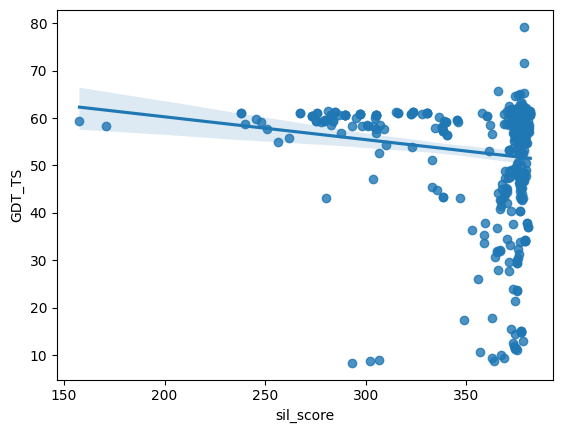

In [44]:
da.grouped_preds = da.phi_psi_predictions.groupby('protein_id').sum(numeric_only=True).sil_score.to_frame()
da.grouped_preds = pd.merge(da.grouped_preds, da.results[['Model', 'GDT_TS']], left_on='protein_id', right_on='Model')
sns.regplot(data=da.grouped_preds, x='sil_score', y='GDT_TS')

# Score by n-neighbors